# Cloud cover - benchmark notebook

From https://www.drivendata.co/blog/cloud-cover-benchmark/.

Originally I'd tried this in the Pytorch 1.8 notebook.  However, I ran into an error when importing Pytorch Lightning:

* `cannot import name 'container_abcs' from 'torch._six'`

This looks like the same errors described in these bugs:

* https://github.com/NVIDIA/apex/issues/1048 -- importing containers_abcs did not work
* https://github.com/qubvel/segmentation_models.pytorch/issues/424 -- upgrading timm did not work

Hopefully I have better luck here.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import torch

NOTE! Installing ujson may make loading annotations faster.


Wait, what?

In [4]:
!pip install --upgrade pandas==1.2.5 pandas_path pytorch_lightning rasterio pyproj xarray xarray-spatial segmentation-models-pytorch ipywidgets  "cloudpathlib[azure]" loguru tqdm typer

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 9.7 MB 21.9 MB/s eta 0:00:01
     |████████████████████████████████| 525 kB 28.8 MB/s eta 0:00:01
     |████████████████████████████████| 19.2 MB 17.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 845 kB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 31.4 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 36.5 MB/s eta 0:00:01
     |████████████████████████████████| 332 kB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 27.5 MB/s eta 0:00:01
     |█████████████████████████

In [3]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import torch

In [4]:
%%file download_data.py

# Source: https://www.drivendata.org/competitions/83/cloud-cover/data/
from pathlib import Path

from cloudpathlib import AzureBlobClient, AzureBlobPath
from loguru import logger
from tqdm.contrib.concurrent import process_map
import typer

app = typer.Typer()


def download_path(path: AzureBlobPath):
    """Downloads a single cloud path."""
    try:
        if path.is_file():
            path.fspath  # downloads cloud asset to local_cache_dir
        return {"path": path, "status": "success"}
    except Exception as exc:
        logger.debug(f"Failed to download {path}. {exc}")
        return {"path": path, "status": "failed", "message": str(exc)}


@app.command()
def main(
    sas_url: str = typer.Option(
        ...,
        help="Shared Access Signature URL that allows you to access the files (starting with "
        "https://...). This can be either the SAS URL itself or a path to a file containing the "
        "SAS URL, available from the competition datasets page.",
    ),
    cloud_directory: str = typer.Option(
        "az://.",
        help="Cloudpathlib URI (`az://./<directory>`) for cloud directory to be downloaded.",
    ),
    local_directory: Path = typer.Option(
        "data",
        help="Directory on your local machine to which the files are downloaded.",
    ),
):
    """Downloads the challenge dataset to your local machine."""
    if Path(sas_url).exists():
        logger.info(f"Loading SAS URL from {sas_url}")
        sas_url = Path(sas_url).read_text().strip()

    client = AzureBlobClient(account_url=sas_url, local_cache_dir=local_directory)
    directory = client.CloudPath(cloud_directory)
    logger.info("Retrieving path list.")
    path_list = [
        path
        for path in directory.rglob("*")
        if path._path.suffix.lower() in (".tif", ".geojson")
    ]
    logger.info(f"Downloading {len(path_list)} files.")
    results = process_map(download_path, path_list, total=len(path_list), chunksize=10)
    failures = [result for result in results if result["status"] == "failed"]
    if len(failures) > 0:
        logger.warning(f"{len(failures)} files failed to download.")


if __name__ == "__main__":
    app()


Overwriting download_data.py


Uncomment the next line to download data.

In [5]:
# !python download_data.py --sas-url ./sas_token

In [21]:
!du -hs data

26G	data


In [6]:
DATA_DIR = Path.cwd() / "data"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

if not TRAIN_FEATURES.exists():
    print("Uh oh, where's my data?")

In [7]:
!ls data/

train_features	train_labels  train_metadata.csv


In [8]:
BANDS = ["B02", "B03", "B04", "B08"]
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

chip_id  location              datetime                   cloudpath
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj

How many different chip ids, locations, and datetimes are there?

In [9]:
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

In [10]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

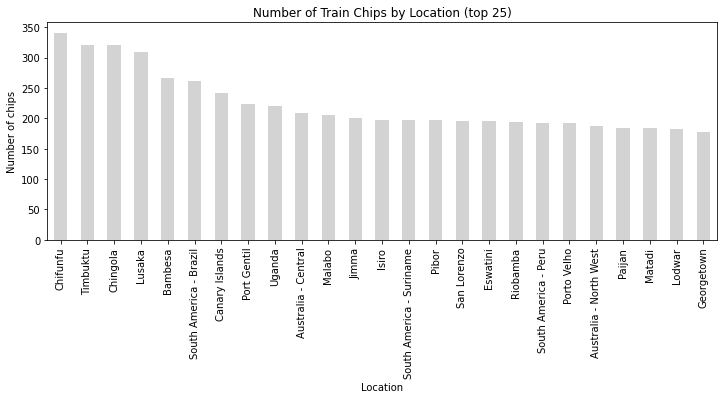

In [11]:
plt.figure(figsize=(12, 4))
train_location_counts.head(25).plot(kind="bar", color="lightgray")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Number of chips")
plt.title("Number of Train Chips by Location (top 25)")
plt.show()

We also have a timestamp for each chip. What is the time range in the data?

In [12]:
train_meta["year"] = pd.to_datetime(train_meta.datetime).dt.year
train_meta.groupby("year")["chip_id"].count()

year
2018      326
2019     1015
2020    10407
Name: chip_id, dtype: int64

In [13]:
train_meta.datetime.min(), train_meta.datetime.max()

('2018-03-07T08:46:02Z', '2020-09-14T08:28:49Z')

In [14]:
(train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .count()
    .sort_values(
        by="chip_id", ascending=False
    )
    .rename(columns={"chip_id": "chip_count"})
).head(10)

chip_count
location                 datetime                        
South America - Brazil   2020-09-06T15:02:37Z         261
Port Gentil              2020-09-08T09:50:58Z         223
Uganda                   2019-04-25T08:29:37Z         220
Australia - Central      2020-08-11T01:24:00Z         209
Malabo                   2020-09-06T10:00:03Z         206
Jimma                    2020-05-31T08:07:58Z         201
Chifunfu                 2020-04-29T08:20:47Z         197
South America - Suriname 2020-06-03T14:11:18Z         197
Isiro                    2020-08-28T08:39:29Z         197
Pibor                    2020-08-17T08:18:22Z         197

For convenience, let's first add the paths to all the features images per chip.  Remember, the folder for each chip has four images, each of which corresponds to a different band of light wavelengths.

In [15]:
train_meta.head()

chip_id  location              datetime                   cloudpath  year
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp  2020
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu  2020
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz  2020
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp  2020
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj  2020

In [16]:
!ls data/train_features/adwp

B02.tif  B03.tif  B04.tif  B08.tif


In [17]:
def get_path(chip_id, band):
    return TRAIN_FEATURES / chip_id / f"{b}.tif"

In [18]:
for band in BANDS:
    train_meta[f"{band}_path"] = TRAIN_FEATURES / train_meta.chip_id / f"{band}.tif"
    assert train_meta[f"{band}_path"].path.exists().all()

train_meta["label_path"] = TRAIN_LABELS / (train_meta.chip_id + ".tif")
assert train_meta["label_path"].path.exists().all()

In [19]:
train_meta.head()

chip_id  location              datetime                   cloudpath  year  \
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp  2020   
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu  2020   
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz  2020   
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp  2020   
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj  2020   

                                            B02_path  \
0  /notebooks/cloud_cover_competition/data/train_...   
1  /notebooks/cloud_cover_competition/data/train_...   
2  /notebooks/cloud_cover_competition/data/train_...   
3  /notebooks/cloud_cover_competition/data/train_...   
4  /notebooks/cloud_cover_competition/data/train_...   

                                            B03_path  \
0  /notebooks/cloud_cover_competition/data/train_...   
1  /notebooks/cloud_cover_competition/data/train_...   
2  /notebooks/cloud_cover_competition/data/train_...   
3  /notebooks/cloud_cover_competition/data/train_...   
4  /notebooks/cloud_cover_competition/data/train_...   

                                            B04_path  \
0  /notebooks/cloud_cover_competition/data/train_...   
1  /notebooks/cloud_cover_competition/data/train_...   
2  /notebooks/cloud_cover_competition/data/train_...   
3  /notebooks/cloud_cover_competition/data/train_...   
4  /notebooks/cloud_cover_competition/data/train_...   

                                            B08_path  \
0  /notebooks/cloud_cover_competition/data/train_...   
1  /notebooks/cloud_cover_competition/data/train_...   
2  /notebooks/cloud_cover_competition/data/train_...   
3  /notebooks/cloud_cover_competition/data/train_...   
4  /notebooks/cloud_cover_competition/data/train_...   

                                          label_path  
0  /notebooks/cloud_cover_competition/data/train_...  
1  /notebooks/cloud_cover_competition/data/train_...  
2  /notebooks/cloud_cover_competition/data/train_...  
3  /notebooks/cloud_cover_competition/data/train_...  
4  /notebooks/cloud_cover_competition/data/train_...

In [20]:
import rasterio


In [21]:
example_chip = train_meta[train_meta.chip_id == "pbyl"]
display(example_chip)

chip_id location              datetime                   cloudpath  year  \
6571    pbyl   Lodwar  2020-09-08T08:09:15Z  az://./train_features/pbyl  2020   

                                               B02_path  \
6571  /notebooks/cloud_cover_competition/data/train_...   

                                               B03_path  \
6571  /notebooks/cloud_cover_competition/data/train_...   

                                               B04_path  \
6571  /notebooks/cloud_cover_competition/data/train_...   

                                               B08_path  \
6571  /notebooks/cloud_cover_competition/data/train_...   

                                             label_path  
6571  /notebooks/cloud_cover_competition/data/train_...

In [22]:
with rasterio.open(example_chip.iloc[0]["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)
    
chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 771935.0,
        0.0, -10.0, 331300.0)}

In [23]:
img_array

array([[ 519,  532,  556, ..., 3662, 3564, 3544],
       [ 549,  539,  562, ..., 3604, 3520, 3518],
       [ 572,  524,  506, ..., 3514, 3488, 3518],
       ...,
       [1216, 2062, 2898, ..., 4050, 3610, 3328],
       [1632, 1932, 2588, ..., 4108, 3918, 3736],
       [1766, 2040, 2272, ..., 4152, 4028, 3824]], dtype=uint16)

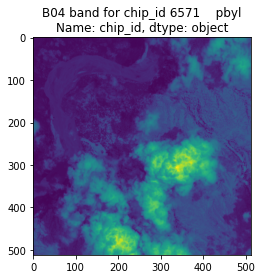

In [24]:
plt.imshow(img_array)
plt.title(f"B04 band for chip_id {example_chip.chip_id}")
plt.show()

In [25]:
img.lnglat(), img.bounds

((35.46935026347422, 2.9714117132510944),
 BoundingBox(left=771935.0, bottom=326180.0, right=777055.0, top=331300.0))

In [26]:
import pyproj

def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, return the image bounds in lat/long coords.
    
    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
        
    # Create converter starting with current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)
    
    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)

In [27]:
example_chip.iloc[0]["B04_path"]

PosixPath('/notebooks/cloud_cover_competition/data/train_features/pbyl/B04.tif')

In [28]:
example_chip["B04_path"].path

<pandas_path.accessor.path_accessor_factory.<locals>.PathAccessor at 0x7f1fe48a11f0>

In [29]:
left, bottom, right, top = lat_long_bounds(example_chip.iloc[0]["B04_path"])
print(
    f"Image coordinates (lat, long):\nStart: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long):
Start: (2.948221298028172, 35.44628398518643)
End: (2.9946024439490517, 35.492417498478574)


In [30]:
import xarray
import xrspatial.multispectral as ms

In [31]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format
    """
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    """Given path to directory of Sentinel-2 chip feature images,
    plot the true color image
    """
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")
    
    return ms.true_color(r=red, g=green, b=blue)


Text(0.5, 1.0, 'True coor image for chip id pbyl')

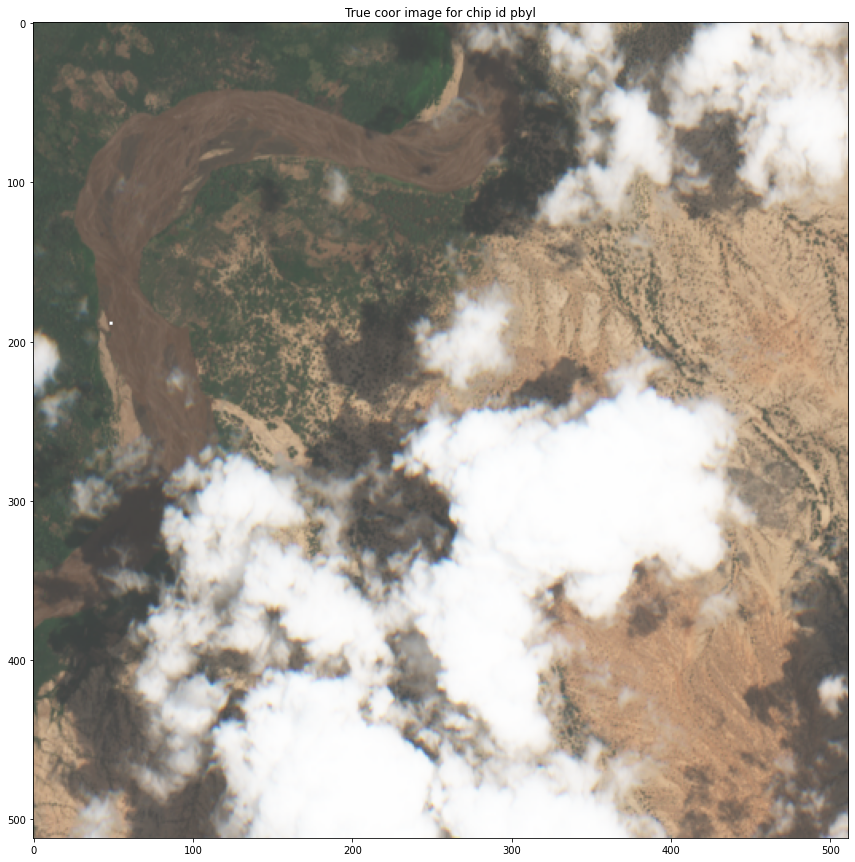

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))
im = true_color_img(example_chip.iloc[0].chip_id)
ax.imshow(im)
plt.title(f"True coor image for chip id {example_chip.iloc[0].chip_id}")

In [33]:
def display_random_chip(random_state=42):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = Image.open(random_chip.label_path)
    ax[1].imshow(label_im)
    ax[1].set_title("Label")
    plt.tight_layout()
    plt.show()

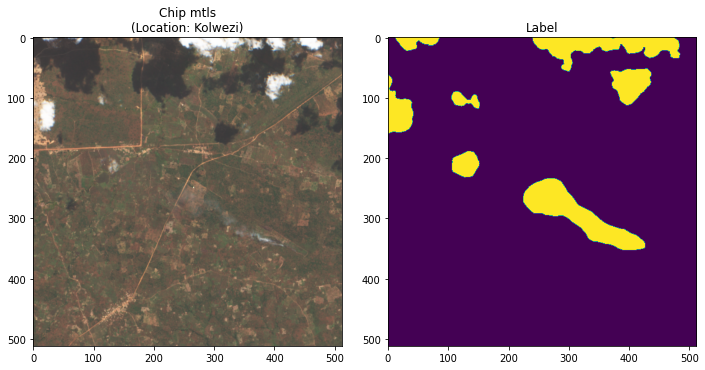

In [34]:
display_random_chip(123)

# Split the data

In [35]:
import random
random.seed(9)

# Put 1/3 into validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape

((3877, 10), (7871, 10))

In [36]:
# Separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]
val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

In [37]:
val_x.head()

chip_id                                           B02_path  \
0    adwz  /notebooks/cloud_cover_competition/data/train_...   
1    aeej  /notebooks/cloud_cover_competition/data/train_...   
2    aeey  /notebooks/cloud_cover_competition/data/train_...   
3    aegb  /notebooks/cloud_cover_competition/data/train_...   
4    aeky  /notebooks/cloud_cover_competition/data/train_...   

                                            B03_path  \
0  /notebooks/cloud_cover_competition/data/train_...   
1  /notebooks/cloud_cover_competition/data/train_...   
2  /notebooks/cloud_cover_competition/data/train_...   
3  /notebooks/cloud_cover_competition/data/train_...   
4  /notebooks/cloud_cover_competition/data/train_...   

                                            B04_path  \
0  /notebooks/cloud_cover_competition/data/train_...   
1  /notebooks/cloud_cover_competition/data/train_...   
2  /notebooks/cloud_cover_competition/data/train_...   
3  /notebooks/cloud_cover_competition/data/train_...   
4  /notebooks/cloud_cover_competition/data/train_...   

                                            B08_path  
0  /notebooks/cloud_cover_competition/data/train_...  
1  /notebooks/cloud_cover_competition/data/train_...  
2  /notebooks/cloud_cover_competition/data/train_...  
3  /notebooks/cloud_cover_competition/data/train_...  
4  /notebooks/cloud_cover_competition/data/train_...

In [38]:
val_y.head()

chip_id                                         label_path
0    adwz  /notebooks/cloud_cover_competition/data/train_...
1    aeej  /notebooks/cloud_cover_competition/data/train_...
2    aeey  /notebooks/cloud_cover_competition/data/train_...
3    aegb  /notebooks/cloud_cover_competition/data/train_...
4    aeky  /notebooks/cloud_cover_competition/data/train_...

In [2]:
# Create benchmark_src folder
submission_dir = Path("benchmark_src")
if submission_dir.exists():
    shutil.rmtree(submission_dir)
    
submission_dir.mkdir(parents=True)

NameError: name 'Path' is not defined

In [48]:
%%file {submission_dir}/cloud_dataset.py
import numpy as np
import pandas as pd
import rasterio
import torch
from typing import Optional, List


class CloudDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, & returns a dict containing
    chip_ids, img tensors, & label masks (where avail)
    """
    
    def __init__(self, x_paths: pd.DataFrame, bands: List[str],
                 y_paths: Optional[pd.DataFrame] = None,
                 transforms: Optional[list] = None,):
        """
        Instantiate CloudDataset class.
        
        Args:
            x_paths(pd.DataFrame): dataframe with row for each chip.  Requires
                a column for chip_id, and a column with the path to the TIF
                for each of the bands.
            bands(list[str]): list of the bands included in the data
            y_paths(pd.DataFrame, optional): a dataframe with chip & columns
                for chip_id
            transforms(list, optional): list of transforms to apply to the feature
                data (augmentations, etc)
        """
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms
        self.bands = bands
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx: int):
        # Load an n-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        band_arrs = []
        for band in self.bands:
            with rasterio.open(img[f"{band}_path"]) as b:
                band_arr = b.read(1).astype("float32")
            band_arrs.append(band_arr)
        x_arr = np.stack(band_arrs, axis=-1)
        
        # Apply transforms if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])
        
        # Prepare dict for each item
        item = {"chip_id": img.chip_id, "chip": x_arr}
        
        # Load label if avail
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1).astype("float32")
            # Apply same transforms to label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            item["label"] = y_arr
            
        return item

Overwriting benchmark_src/cloud_dataset.py


In [49]:
%%file {submission_dir}/losses.py
import numpy as np


# TODO: types
def intersection_over_union(pred, true):
    """
    Calculate intersection and union for a batch of images.
    
    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torch.Tensor): a tensor of labels
        
    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)   # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")
    
    # Intersection & Union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum() / union.sum()

Overwriting benchmark_src/losses.py


In [20]:
%%file benchmark_src/cloud_model.py
from typing import Optional, List

from loguru import logger
import pandas as pd
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch

try:
    from cloud_dataset import CloudDataset
    from losses import intersection_over_union
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.losses import intersection_over_union
    
class CloudModel(pl.LightningModule):
    
    def __init__(
        self,
        bands: List[str],
        x_train: Optional[pd.DataFrame] = None,
        y_train: Optional[pd.DataFrame] = None,
        x_val: Optional[pd.DataFrame] = None,
        y_val: Optional[pd.DataFrame] = None,
        hparams: dict = {}
    ):
        """Instantiate CLoudModel class based on pytorch-lightning model."""
        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()
        
        # required
        self.bands = bands
        
        # Optional modelling params
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.gpu = self.hparams.get("gpu", False)
        self.transform = None
        
        logger.debug(f"Setting batch size to {self.batch_size}")
        # Instantiate datasets, model & trainer params if provided
        self.train_dataset = CloudDataset(
            x_paths=x_train,
            bands=self.bands,
            y_paths=y_train,
            transforms=self.transform,
        )
        self.val_dataset = CloudDataset(
            x_paths=x_val,
            bands=self.bands,
            y_paths=y_val,
            transforms=None,
        )
        self.model = self._prepare_model()
        
    # Required LightningModule methods
    def forward(self, image: torch.Tensor):
        # Forward pass
        return self.model(image)
    
    def training_step(self, batch: dict, batch_idx: int):
        """Training step.
        """
        if self.train_dataset.data is None:
            raise ValueError(
                "x_train & y_train must be specified when CloudModel is instantiated to run training"
            )
            
        # Turn on training mode
        self.model.train()
        torch.set_grad_enabled(True)
        
        # Load chips & labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
            
        # Forward pass
        preds = self.forward(x)
        
        # Log batch loss
        loss = torch.nn.CrossEntropyLoss(reduction="none")(preds, y).mean()
        self.log(
            "loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss
    
    def validation_step(self, batch: dict, batch_idx: int):
        """Validation step.
        """
        if self.val_dataset.data is None:
            raise ValueError(
                "x_val & y_val must be specified when CloudModel is instantiated to run validation"
            )
        
        # Turn on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)
        
        # Load images & labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
            
        # Forward pass, softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1  # convert to int
        
        # Log batch IOU
        batch_iou = intersection_over_union(preds, y)
        self.log(
            "iou",
            batch_iou, 
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return batch_iou
    
    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )
    
    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=8,
            shuffle=False,
            pin_memory=True
        )
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            self.model.parameters(),
            lr=self.learning_rate,
        )
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]
    
    # And now some convenience methods
    def _prepare_model(self):
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=4,
            classes=2
        )
        if self.gpu:
            unet_model.cuda()
            
        return unet_model

Overwriting benchmark_src/cloud_model.py


# Let's fit a model! 🤘

In [69]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
%%file benchmark_src/train.py

from pathlib import Path
import random

from loguru import logger
import pandas as pd
import pytorch_lightning as pl
from pandas_path import path

from cloud_model import CloudModel

logger.debug("Constants time:")
BANDS = ["B02", "B03", "B04", "B08"]

DATA_DIR = Path.cwd() / "../data"
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

# To match benchmark
random.seed(9)


if not TRAIN_FEATURES.exists():
    logger.warning("Uh oh, where's my data?")

def get_path(chip_id, band):
    return TRAIN_FEATURES / chip_id / f"{b}.tif"

logger.debug("About to set bandpath...")
for band in BANDS:
    train_meta[f"{band}_path"] = TRAIN_FEATURES / train_meta.chip_id / f"{band}.tif"
    # assert train_meta[f"{band}_path"].path.exists().all()

logger.debug("About to set label path...")
train_meta["label_path"] = TRAIN_LABELS / (train_meta.chip_id + ".tif")
# assert train_meta["label_path"].path.exists().all()


# Put 1/3 into validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

logger.debug(f"Val shape: {val.shape}")
logger.debug(f"Train shape: {train.shape}")

# Separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]
val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

# Set up pytorch_lightning.Trainer object
# Training time seems to be about 50 mins (estimate, about 8 mins after starting) with batch size 16, num workers 8, and val_loader num_workers 0.
# Oh, interesting: training time seems to be closer to 2h with val_loader num_worker set to 8.
# ---scratch that; after 7 minutes, came down to ~ 48 mins...so about the same as above.
cloud_model = CloudModel(
    bands=BANDS,
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y,
    hparams={"batch_size": 16,   # 16 appears to work for the P4000 I'm on.  
             "num_workers": 8},  # GPU OOM
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="iou_epoch",
    mode="max",
    verbose=True,
)

early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(cloud_model.patience * 3),
    mode="max",
    verbose=True,
)

trainer = pl.Trainer(
    # gpus=None,
    accelerator="gpu",
    gpus=1,
    auto_select_gpus=True,
    fast_dev_run=False,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

# And now we fit!

# Note: tripped over https://github.com/pandas-dev/pandas/issues/42748 at this point:
# AttributeError: 'functools.partial' object has no attribute '__name__'
# https://stackoverflow.com/questions/68694047/pytorch-lightning-functools-partial-error
# 
# rreinstalled pandas 1.2.5.

trainer.fit(model=cloud_model)
torch.save(cloud_model.state_dict(), "cloud_model")

Overwriting benchmark_src/train.py


# FIXME

I suspect that I'm not de-allocating memory when I adjust the batch size, and may need to restart the kernel.  Going down from batch size of 32 to 16 to 8 did nothing.

In [72]:
%%file final_run.py
# Set up pytorch_lightning.Trainer object
cloud_model = CloudModel(
    bands=BANDS,
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y,
    hparams={"batch_size": 8},  # GPU OOM
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="iou_epoch",
    mode="max",
    verbose=True,
)

early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(cloud_model.patience * 3),
    mode="max",
    verbose=True,
)

trainer = pl.Trainer(
    # gpus=None,
    accelerator="gpu",
    gpus=1,
    auto_select_gpus=True,
    fast_dev_run=False,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

# And now we fit!

# Note: tripped over https://github.com/pandas-dev/pandas/issues/42748 at this point:
# AttributeError: 'functools.partial' object has no attribute '__name__'
# https://stackoverflow.com/questions/68694047/pytorch-lightning-functools-partial-error
# 
# rreinstalled pandas 1.2.5.

trainer.fit(model=cloud_model)

Writing final_run.py


In [2]:
%%file benchmark_src/predict.py
import os
from pathlib import Path
from typing import List

from loguru import logger
import pandas as pd
from PIL import Image
import torch
import typer

try:
    from cloud_dataset import CloudDataset
    from cloud_model import CloudModel
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.cloud_model import CloudModel


ROOT_DIRECTORY = Path("/codeexecution")
PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / "predictions"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Set the pytorch cache directory and include cached models in your submission.zip
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "assets/torch")


def get_metadata(features_dir: os.PathLike, bands: List[str]):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in chip_ids:
        chip_bands = [features_dir / chip_id / f"{band}.tif" for band in bands]
        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})


def make_predictions(
    model: CloudModel,
    x_paths: pd.DataFrame,
    bands: List[str],
    predictions_dir: os.PathLike,
):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        bands (list[str]): list of bands provided for each chip
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
    test_dataset = CloudDataset(x_paths=x_paths, bands=bands)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=model.batch_size,
        num_workers=model.num_workers,
        shuffle=False,
        pin_memory=True,
    )

    for batch_index, batch in enumerate(test_dataloader):
        logger.debug(f"Predicting batch {batch_index} of {len(test_dataloader)}")
        x = batch["chip"]
        preds = model.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5).detach().numpy().astype("uint8")
        for chip_id, pred in zip(batch["chip_id"], preds):
            chip_pred_path = predictions_dir / f"{chip_id}.tif"
            chip_pred_im = Image.fromarray(pred)
            chip_pred_im.save(chip_pred_path)


def main(
    model_weights_path: Path = ASSETS_DIRECTORY / "cloud_model.pt",
    test_features_dir: Path = DATA_DIRECTORY / "test_features",
    predictions_dir: Path = PREDICTIONS_DIRECTORY,
    bands: List[str] = ["B02", "B03", "B04", "B08"],
    fast_dev_run: bool = False,
):
    """
    Generate predictions for the chips in test_features_dir using the model saved at
    model_weights_path.

    Predictions are saved in predictions_dir. The default paths to all three files are based on
    the structure of the code execution runtime.

    Args:
        model_weights_path (os.PathLike): Path to the weights of a trained CloudModel.
        test_features_dir (os.PathLike, optional): Path to the features for the test data. Defaults
            to 'data/test_features' in the same directory as main.py
        predictions_dir (os.PathLike, optional): Destination directory to save the predicted TIF masks
            Defaults to 'predictions' in the same directory as main.py
        bands (List[str], optional): List of bands provided for each chip
    """
    if not test_features_dir.exists():
        raise ValueError(
            f"The directory for test feature images must exist and {test_features_dir} does not exist"
        )
    predictions_dir.mkdir(exist_ok=True, parents=True)

    logger.info("Loading model")
    model = CloudModel(bands=bands, hparams={"weights": None})
    model.load_state_dict(torch.load(model_weights_path))

    logger.info("Loading test metadata")
    test_metadata = get_metadata(test_features_dir, bands=bands)
    if fast_dev_run:
        test_metadata = test_metadata.head()
    logger.info(f"Found {len(test_metadata)} chips")

    logger.info("Generating predictions in batches")
    make_predictions(model, test_metadata, bands, predictions_dir)

    logger.info(f"""Saved {len(list(predictions_dir.glob("*.tif")))} predictions""")


if __name__ == "__main__":
    typer.run(main)

Writing benchmark_src/predict.py
